# Imports

In [2]:
import pandas as pd
import numpy as np
import os
import requests
import sys
import json
from datetime import datetime, timedelta
import holidays
import scipy
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 15

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve, plot_roc_curve, confusion_matrix, accuracy_score
import xgboost as xgb

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from scipy.stats import reciprocal, uniform, randint

## Constants

In [3]:
random_state = 42
np.random.seed(random_state)

## Functions

In [4]:
def get_roc_scores(model, X, y):
    y_scores = model.predict_proba(X)[:, 1]
    fpr, tpr, thresholds = roc_curve(y, y_scores)
    i = np.argmax(tpr - fpr)
    return fpr, tpr, thresholds, i, y_scores

def plot_roc_threshold_curves(model, X, y, modelName = "Default"):
    fpr, tpr, thresholds, i, y_scores = get_roc_scores(model, X, y)
    print(modelName,"ROC AUC Score -",round(roc_auc_score(y,y_scores),3))
    plt.plot(fpr, tpr, linewidth=4, label=modelName)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.legend(loc="lower right", fontsize=16)
    plt.scatter(fpr[i], tpr[i], c='r', s=100)
    plt.title('ROC Curve');

# Data Modelling

## Import Cleaned CSV

In [6]:

data_path = "../data/final_trip_feature_data.csv"
df_full_non_zero_net_demand_trim = pd.read_csv(data_path)

In [7]:
df_full_non_zero_net_demand_trim = df_full_non_zero_net_demand_trim.rename(columns={
    "Start Station Id" : "Station Id",
    "Binned_Start_Time" : "Time",
    "capacity" : "Station Capacity",
    "nearest_transit" : "Nearest Transit Station Name",
    "POI_distance" : "Distance to Nearest Transit Station",
    "Is_Weekend" : "Weekend",
    "Active_TO" : "Active TO",
    "Lockdown_Stay_at_Home" : "Lockdown"
})

In [8]:
df_full_non_zero_net_demand_trim[['Active TO','Lockdown','Holiday','Weekend']] = df_full_non_zero_net_demand_trim[['Active TO','Lockdown','Holiday','Weekend']].astype(pd.SparseDtype("int64",0))

In [9]:
df_full_non_zero_net_demand_trim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1912438 entries, 0 to 1912437
Data columns (total 18 columns):
 #   Column                               Dtype           
---  ------                               -----           
 0   Station Id                           int64           
 1   Time                                 object          
 2   Station Capacity                     int64           
 3   Nearest Transit Station Name         object          
 4   Distance to Nearest Transit Station  float64         
 5   Temp (°C)                            float64         
 6   Precip. Amount (mm)                  float64         
 7   Wind Spd (km/h)                      float64         
 8   Wind Dir (10s deg)                   float64         
 9   Visibility (km)                      float64         
 10  Holiday                              Sparse[int64, 0]
 11  Weekend                              Sparse[int64, 0]
 12  Year                                 int64           
 1

In [10]:
#Samples of the original dataset were used for certain models to get early indication of model performance.
#df_full_non_zero_net_demand_trim = df_full_non_zero_net_demand_trim.sample(frac = 0.1, random_state = 42)

In [11]:
df_full_non_zero_net_demand_trim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1912438 entries, 0 to 1912437
Data columns (total 18 columns):
 #   Column                               Dtype           
---  ------                               -----           
 0   Station Id                           int64           
 1   Time                                 object          
 2   Station Capacity                     int64           
 3   Nearest Transit Station Name         object          
 4   Distance to Nearest Transit Station  float64         
 5   Temp (°C)                            float64         
 6   Precip. Amount (mm)                  float64         
 7   Wind Spd (km/h)                      float64         
 8   Wind Dir (10s deg)                   float64         
 9   Visibility (km)                      float64         
 10  Holiday                              Sparse[int64, 0]
 11  Weekend                              Sparse[int64, 0]
 12  Year                                 int64           
 1

### Train Test Split

In [12]:
X = df_full_non_zero_net_demand_trim.drop("Positive Net Demand", axis = 1)
Y = df_full_non_zero_net_demand_trim["Positive Net Demand"].copy()

In [13]:
X_train_pre_pipeline, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state = random_state, stratify = Y)

## Pipeline Creation

In [14]:
# This class is defined in the textbook and simply restricts the dataframe to specific features
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names=attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [15]:
num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(['Station Capacity','Distance to Nearest Transit Station', 'Temp (°C)', 'Precip. Amount (mm)', 'Wind Spd (km/h)',
           'Month','Holiday', 'Weekend', 'Active TO', 'Lockdown'])),
            ('std_scaler', RobustScaler())
    ])

In [16]:
cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(['Time', 'Nearest Transit Station Name'])),
        ("cat_encoder", OneHotEncoder(categories='auto')),
    ])

In [17]:
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [18]:
X_train_prepared = preprocess_pipeline.fit_transform(X_train_pre_pipeline)

In [19]:
X_train_prepared.shape

(1338706, 76)

In [20]:
y_train_ravel = np.ravel(y_train)

# *MODELLING NOTES*
Due to the number of observations being close to 2M, the Active AI team used our local PCs to perform grid searches and cross-valications on the high coputational models, such as desicion trees, random forest and EDA Boost and XG Boost.

Sample code of the grid search is below, and lines of code have been inserted  as examples to show that cross-validations were also compelted.

# Logistic Regression Classifier

In [ ]:
log_clf_pregrid = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=random_state)

param_grid = [{'C': [0.1,0.5,1]}]

grid_search_log_clf = GridSearchCV(log_clf_pregrid, param_grid, cv=3 ,scoring='roc_auc', n_jobs = -1, verbose = 10)
grid_search_log_clf.fit(X_train_prepared, y_train_ravel)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=1000, random_state=42),
             n_jobs=-1, param_grid=[{'C': [0.1, 0.5, 1]}], scoring='roc_auc',
             verbose=10)

In [ ]:
log_clf = grid_search_log_clf.best_estimator_
score = cross_val_score(log_clf, X_train_prepared, y_train_ravel, cv=3, verbose=3, scoring = 'roc_auc', n_jobs=-1)
score.mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.6s finished


0.5671763612335331

Log Reg Classifier ROC AUC Score - 0.57


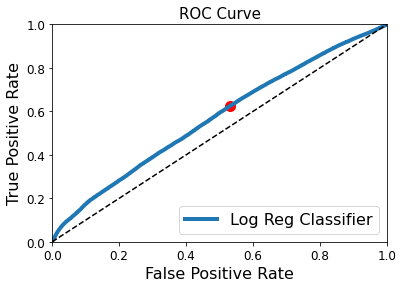

In [ ]:
plot_roc_threshold_curves(log_clf, X_train_prepared, y_train_ravel, "Log Reg Classifier")

# Polynomial Logistic Regression Classifier

## Degree = 2

In [ ]:
poly_features_2 = PolynomialFeatures(degree=2, include_bias=False)
X_train_prepared_poly_2 = poly_features_2.fit_transform(X_train_prepared)

In [ ]:
log_clf_2 = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=random_state)
score_2 = cross_val_score(log_clf_2, X_train_prepared_poly_2, y_train_ravel, cv=3, verbose=10, scoring = 'roc_auc')
score_2.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] START .....................................................................
[CV] END ................................ score: (test=0.611) total time=   6.8s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.8s remaining:    0.0s


[CV] END ................................ score: (test=0.608) total time=   6.7s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.6s remaining:    0.0s


[CV] END ................................ score: (test=0.611) total time=   7.2s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   20.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   20.9s finished


0.6104519204398392

In [ ]:
log_clf_2.fit(X_train_prepared_poly_2, y_train_ravel)

LogisticRegression(max_iter=1000, random_state=42)

Log Reg Classifier (Poly = 2) ROC AUC Score - 0.632


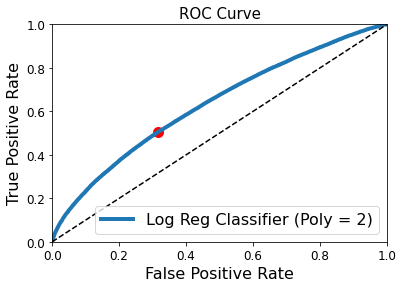

In [ ]:
plot_roc_threshold_curves(log_clf_2, X_train_prepared_poly_2, y_train_ravel, "Log Reg Classifier (Poly = 2)")

## Degree = 3

In [ ]:
poly_features_3 = PolynomialFeatures(degree=3, include_bias=False)
X_train_prepared_poly_3 = poly_features_3.fit_transform(X_train_prepared)

In [ ]:
log_clf_3 = LogisticRegression(solver="lbfgs", max_iter=2000, random_state=random_state)
score_3 = cross_val_score(log_clf_3, X_train_prepared_poly_3, y_train_ravel, cv=3, verbose=10, scoring = 'roc_auc')
score_3.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] START .....................................................................


C:\Users\ibadi\anaconda3\envs\ds_cert_ml_course\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ................................ score: (test=0.653) total time=10.3min
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 10.3min remaining:    0.0s
C:\Users\ibadi\anaconda3\envs\ds_cert_ml_course\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ................................ score: (test=0.654) total time=10.1min
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 20.4min remaining:    0.0s
C:\Users\ibadi\anaconda3\envs\ds_cert_ml_course\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ................................ score: (test=0.653) total time=10.2min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 30.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 30.6min finished


0.6534014996544096

In [ ]:
log_clf_3.fit(X_train_prepared_poly_3, y_train_ravel)

C:\Users\ibadi\anaconda3\envs\ds_cert_ml_course\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=2000, random_state=42)

Log Reg Classifier (Poly = 3) ROC AUC Score - 0.664


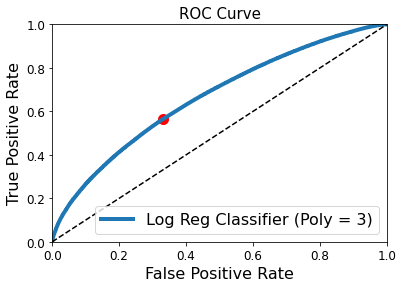

In [ ]:
plot_roc_threshold_curves(log_clf_3, X_train_prepared_poly_3, y_train_ravel, "Log Reg Classifier (Poly = 3)")

# Check Point ROC Curves - Log Regression + Polynomial Log Regression

Log Reg Classifier ROC AUC Score - 0.569
Log Reg Classifier (Poly = 2) ROC AUC Score - 0.625
Log Reg Classifier (Poly = 3) ROC AUC Score - 0.664


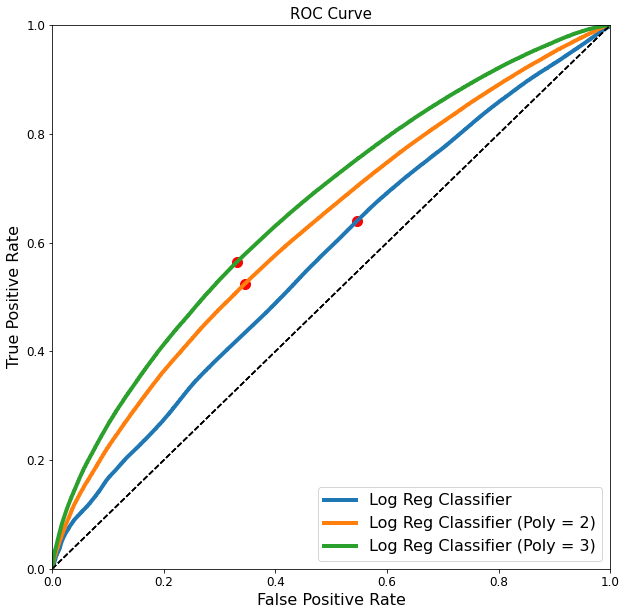

In [ ]:
plt.figure(figsize=(10, 10))
plot_roc_threshold_curves(log_clf, X_train_prepared, y_train_ravel, "Log Reg Classifier")
plot_roc_threshold_curves(log_clf_2, X_train_prepared_poly_2, y_train_ravel, "Log Reg Classifier (Poly = 2)")
plot_roc_threshold_curves(log_clf_3, X_train_prepared_poly_3, y_train_ravel, "Log Reg Classifier (Poly = 3)")


# AdaBoost

## AdaBoost with default base classifier

In [ ]:
tree_clf = AdaBoostClassifier(random_state=random_state)

In [ ]:
scores = cross_val_score(tree_clf, X_train_prepared, y_train_ravel, n_jobs=-1, verbose =10, cv=3, scoring = 'roc_auc')
scores.mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.6s finished


0.5670933568820542

In [ ]:
tree_clf.fit(X_train_prepared, y_train_ravel)

AdaBoostClassifier(random_state=42)

Ada Boost - Base Classifier ROC AUC Score - 0.57


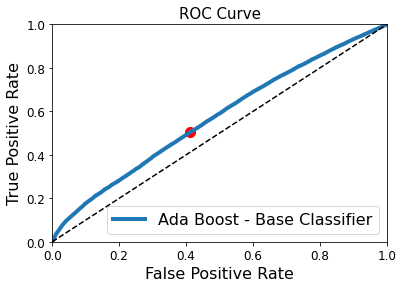

In [ ]:
plot_roc_threshold_curves(tree_clf, X_train_prepared, y_train_ravel, "Ada Boost - Base Classifier")

### Decision Tree 

In [ ]:
base_tree_clf = DecisionTreeClassifier(criterion = 'gini',max_depth = 20, max_leaf_nodes = 432, min_samples_leaf = 200, min_samples_split = 198)

In [ ]:
scores = cross_val_score(base_tree_clf, X_train_prepared, y_train_ravel, n_jobs=-1, verbose =10, cv=3, scoring = 'roc_auc')
scores.mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished


0.6204486952001412

In [ ]:
base_tree_clf.fit(X_train_prepared, y_train_ravel)

DecisionTreeClassifier(max_depth=20, max_leaf_nodes=432, min_samples_leaf=200,
                       min_samples_split=198)

Decision Tree ROC AUC Score - 0.659


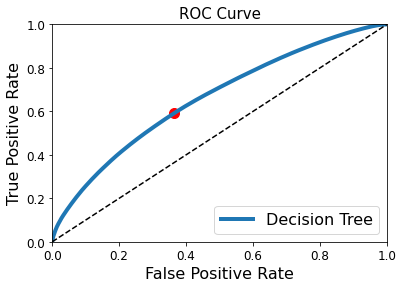

In [ ]:
plot_roc_threshold_curves(base_tree_clf, X_train_prepared, y_train_ravel, "Decision Tree")

### Ada Boost Desicion Tree

In [ ]:
ada_tree_clf = AdaBoostClassifier(base_estimator = base_tree_clf, random_state=random_state, algorithm='SAMME.R')

In [ ]:
param_1 = {'n_estimators': [100,200,500]}

ada_tree_clf_1 = GridSearchCV(ada_tree_clf, param_1, cv=3 ,scoring='roc_auc', n_jobs = -1, verbose = 10)
ada_tree_clf_1.fit(X_train_prepared, y_train_ravel)
score_1 = ada_tree_clf_1.cv_results_['mean_test_score']

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [ ]:
ada_tree_clf_final = ada_tree_clf_1.best_estimator_
ada_tree_clf_final =  AdaBoostClassifier(base_estimator = base_tree_clf, random_state=random_state, algorithm='SAMME.R',n_estimators = 100)
score = cross_val_score(ada_tree_clf_final, X_train_prepared, y_train_ravel, cv=3, verbose=3, scoring = 'roc_auc', n_jobs=-1)
score.mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.7min finished


0.5972678153062135

In [ ]:
ada_tree_clf_final.fit(X_train_prepared, y_train_ravel)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=20,
                                                         max_leaf_nodes=432,
                                                         min_samples_leaf=200,
                                                         min_samples_split=198),
                   n_estimators=100, random_state=42)

Ada Boost - Decision Tree ROC AUC Score - 0.894


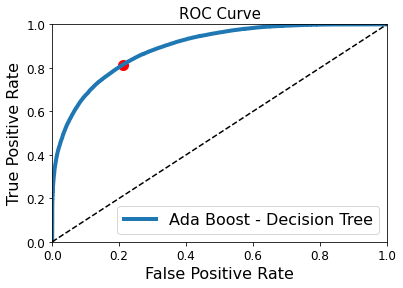

In [ ]:
plot_roc_threshold_curves(ada_tree_clf_final, X_train_prepared, y_train_ravel, "Ada Boost - Decision Tree")

The above curve compared to the cross validation results shows that the current training model is overfitting.

# Random Forest


Random Forest ROC AUC Score - 0.659


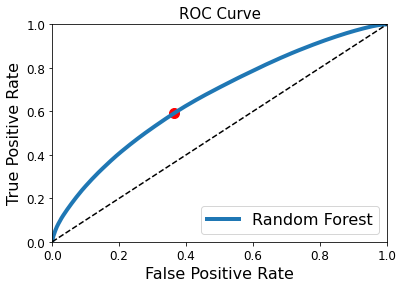

In [ ]:
rf = RandomForestClassifier(random_state = 42, n_jobs=-1, n_estimators=500, max_depth=10)
rf.fit(X_train_prepared, y_train_ravel)
plot_roc_threshold_curves(base_tree_clf, X_train_prepared, y_train_ravel, "Random Forest")

Ada Boost - Base Classifier ROC AUC Score - 0.566
Decision Tree ROC AUC Score - 0.633
Ada Boost - Decision Tree ROC AUC Score - 0.619
Random Forest ROC AUC Score - 0.633


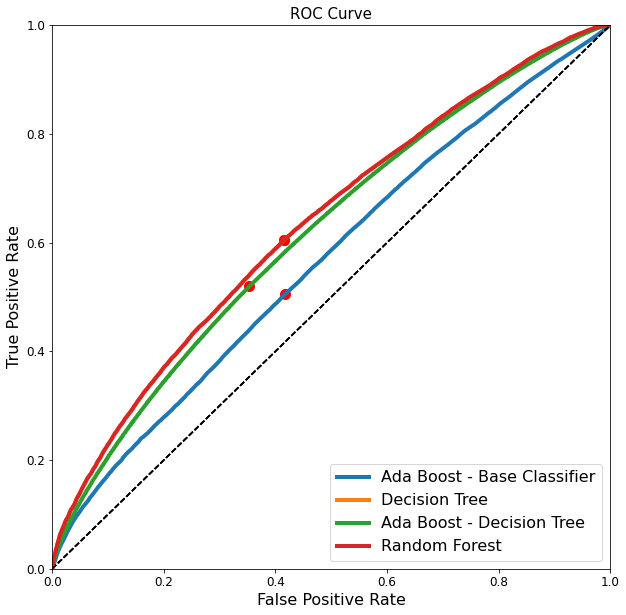

In [ ]:
plt.figure(figsize=(10, 10))
plot_roc_threshold_curves(tree_clf, X_train_prepared, y_train_ravel, "Ada Boost - Base Classifier")
plot_roc_threshold_curves(base_tree_clf, X_train_prepared, y_train_ravel, "Decision Tree")
plot_roc_threshold_curves(ada_tree_clf_final, X_train_prepared, y_train_ravel, "Ada Boost - Decision Tree")
plot_roc_threshold_curves(base_tree_clf, X_train_prepared, y_train_ravel, "Random Forest")

# XGBoost

Grid search was split into individual cross-validation runs to avoid computational capacity issues. Sample code of grid search is below.

In [ ]:
xgb_model = xgb.XGBClassifier(colsample_bytree =  0.9, min_child_weight = 3, 
                                  n_estimators = 100, subsample = 0.9 , n_jobs = -1)

param_2 = {'max_depth': [15,20,25,30,35]}

xgb_model_1 = GridSearchCV(xgb_model, param_2, cv=3 ,scoring='roc_auc', n_jobs = -1, verbose = 10)
xgb_model_1.fit(X_train_prepared, y_train_ravel)
score_xgb_1 = xgb_model_1.cv_results_['mean_test_score']

In [21]:
xgb_model = xgb.XGBClassifier(colsample_bytree =  0.9, 
                                  max_depth = 25, min_child_weight = 3, 
                                  n_estimators = 100, subsample = 0.9 , n_jobs = -1)
xgb_model.fit(X_train_prepared, y_train)

XGBClassifier(colsample_bytree=0.9, max_depth=25, min_child_weight=3, n_jobs=-1,
              subsample=0.9)

In [22]:
y_pred = xgb_model.predict_proba(X_train_prepared)[:, 1]
roc_auc_score(y_train, y_pred)

0.9020838751700887

XGboost - Overfit ROC AUC Score - 0.902


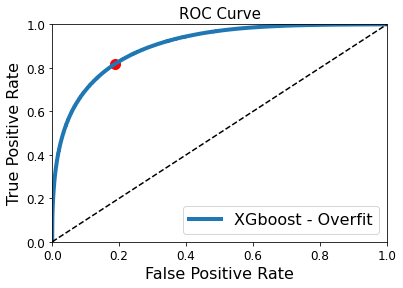

In [24]:
plot_roc_threshold_curves(xgb_model, X_train_prepared, y_train, modelName = "XGboost - Overfit")

## XGBoost Final

In [ ]:
xgb_model = xgb.XGBClassifier(colsample_bytree =  0.65, 
                                  max_depth = 22, min_child_weight = 7, 
                                  gamma = 8,
                                  learning_rate=0.05,
                                  n_estimators = 90, subsample = 0.65 , n_jobs = -1)
xgb_model.fit(X_train_prepared, y_train_ravel)

C:\Users\ibadi\anaconda3\envs\ds_cert_ml_course\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:40:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.65,
              enable_categorical=False, gamma=8, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=22,
              min_child_weight=7, missing=nan, monotone_constraints='()',
              n_estimators=90, n_jobs=-1, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.65, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [ ]:
y_pred = xgb_model.predict_proba(X_train_prepared)[:, 1]
roc_auc_score(y_train, y_pred)

0.7168979732121521

XGboost ROC AUC Score - 0.717


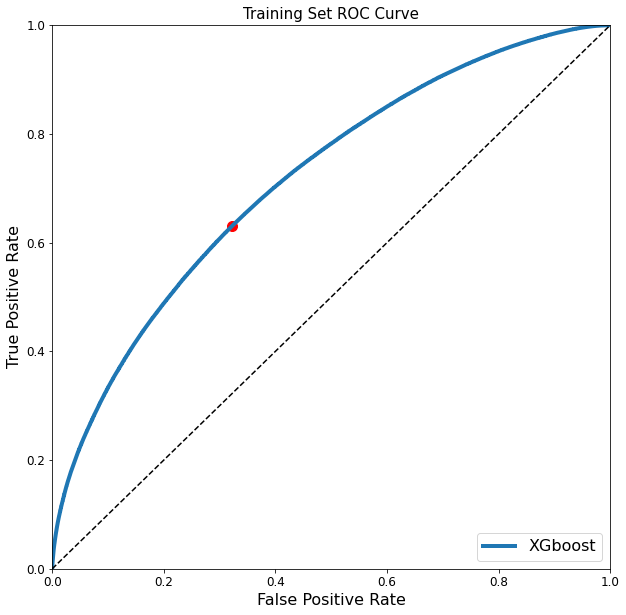

In [ ]:
plt.figure(figsize=(10, 10))
plot_roc_threshold_curves(xgb_model, X_train_prepared, y_train, modelName = "XGboost")
plt.title('Training Set ROC Curve');

In [ ]:
X_test_prepared = preprocess_pipeline.fit_transform(X_test)

In [ ]:
y_test_pred = xgb_model.predict_proba(X_test_prepared)[:, 1]
roc_auc_score(y_test, y_test_pred)

0.693545976199242

XGboost ROC AUC Score - 0.694


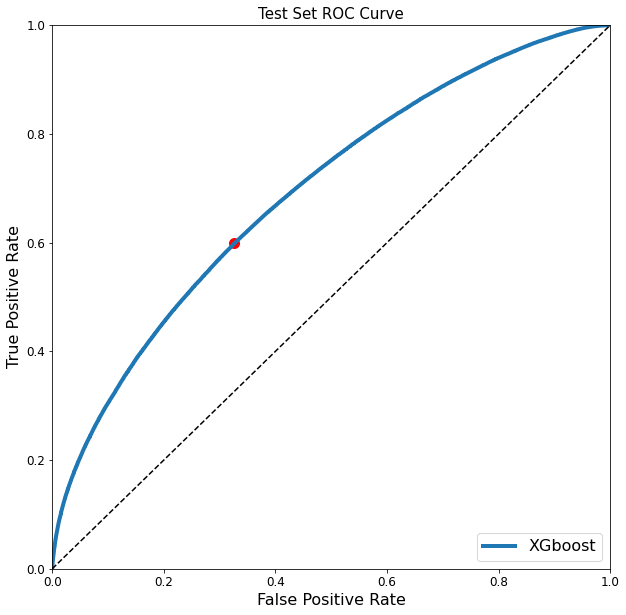

In [ ]:
plt.figure(figsize=(10, 10))
plot_roc_threshold_curves(xgb_model, X_test_prepared, y_test, modelName = "XGboost")
plt.title('Test Set ROC Curve');

## Feature Importance

In [ ]:
def get_top_features(model, n):
  #feature_names = list(num_var) + list(cat_one_hot)
  feature_imp = model.feature_importances_
  zipped = zip (feature_names, feature_imp)
  sorted_feature = sorted(zipped, key = lambda t: t[1], reverse=True)
  return sorted_feature[:n]

In [ ]:
xgb_importance = pd.DataFrame(get_top_features(xgb_model, 40), columns = ('feature', 'importance'))

In [ ]:
xgb_importance.head(2)

,feature,importance
0,x1_Queen's Park,0.086769
1,x1_Sherbourne,0.049834


In [ ]:
xgb_importance[1]

0    x1_Sherbourne
1         0.049834
Name: 1, dtype: object

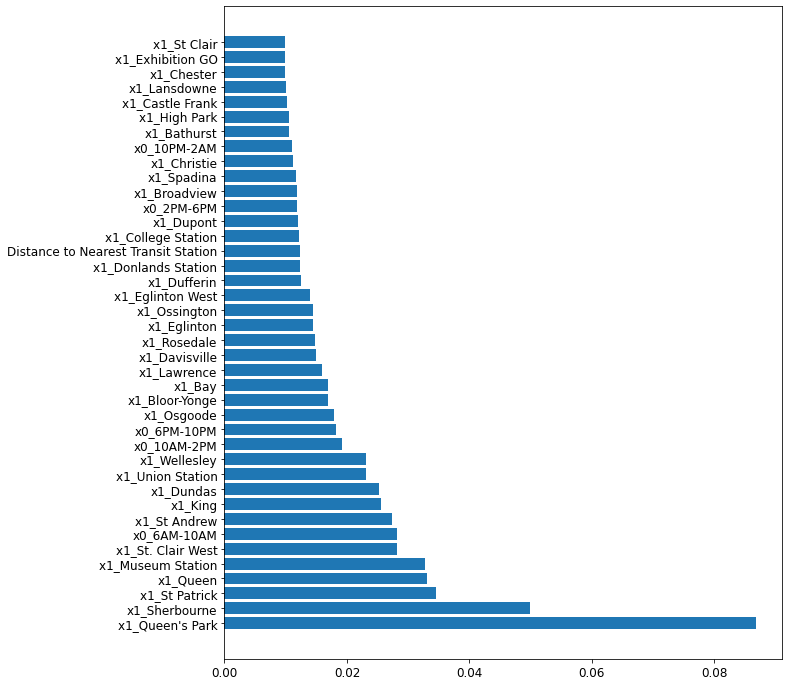

In [ ]:
plt.figure(figsize=(10,12))
plt.barh(xgb_importance['feature'],xgb_importance['importance'])
plt.show()